In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import xml.etree.ElementTree as ET
from torch.autograd import Variable
from torch import optim

In [2]:
def get_labels(base,name):
    labels = []
    tree = ET.parse(base+name)
    root = tree.getroot()
    for child in root:
        if child.tag == 'object':
            for obj in child:
                if obj.tag == 'name':
                    labels.append(obj.text)

    return sorted(list(set(labels)))

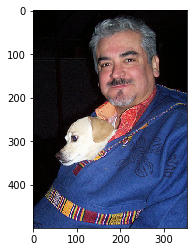

In [3]:
images_path = "../VOCdevkit/VOC2007/JPEGImages/"
annotations_path= "../VOCdevkit/VOC2007/Annotations/"
image_filenames = os.listdir(images_path)
train_images = []
train_labels = []
unique_labels = {}
for filename in image_filenames:
    my_image = Image.open(images_path + filename)
    train_images.append(my_image.copy())
    my_image.close()

    my_labels = get_labels(annotations_path,filename.split(".")[0]+'.xml')

    for label in my_labels:
        if label not in unique_labels:
            unique_labels[label] = len(unique_labels)
    
    my_labels = [unique_labels[label] for label in my_labels]
    
    train_labels.append(my_labels)
            
    
plt.imshow(np.asarray(train_images[0]))

In [4]:
train_labels[:10]

[[0, 1], [2], [3, 4], [5], [3, 6, 7], [3], [8, 1], [9], [10], [11, 5, 1]]

In [5]:
unique_labels

{'dog': 0,
 'person': 1,
 'train': 2,
 'chair': 3,
 'sofa': 4,
 'car': 5,
 'diningtable': 6,
 'pottedplant': 7,
 'horse': 8,
 'cat': 9,
 'cow': 10,
 'bus': 11,
 'bicycle': 12,
 'motorbike': 13,
 'bird': 14,
 'tvmonitor': 15,
 'sheep': 16,
 'aeroplane': 17,
 'boat': 18,
 'bottle': 19}

In [6]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
train_images = [transform(i) for i in train_images]


In [7]:
one_hot_train_labels = []
for labels in train_labels:
    one_hot = [0 for i in range(len(unique_labels))]
    for index in labels:
        one_hot[index] = 1
    one_hot_train_labels.append(torch.Tensor(one_hot))
    
one_hot_train_labels = torch.stack(one_hot_train_labels)
one_hot_train_labels

tensor([[1., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [8]:
train_data = []
for i in range(len(train_images)):
    train_data.append([train_images[i], one_hot_train_labels[i]])

In [9]:
train_split = 0.7
train_data, validation_data = torch.utils.data.random_split(train_data, [int(train_split*len(train_data)), len(train_data) - int(train_split*len(train_data))])

In [10]:
batch_size = 20
num_classes = len(unique_labels)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
validation_data_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=False)

In [11]:
def train(data_loader, classifier, loss_function, optimizer, threshold=0.5):
    classifier.train()
    
    loss = 0
    losses = []
    
    precision = 0
    precisions = []
    
    recall = 0
    recalls = []
    
    f1_score = 0
    f1_scores = []
    
    iou = 0
    ious = []
    
    for i, (images, labels) in enumerate(data_loader):
        
#         if this is the final batch in this epoch and is not a full batch, skip it
        if(images.shape[0] != batch_size):
            break
        
        images = images.cuda()
#         print(images.shape)
        labels = labels.cuda()
#         print(labels)
#         labels = [torch.Tensor(label).cuda() for label in labels]
        
    
        optimizer.zero_grad()
        predictions = classifier(images)

        loss = loss_function(predictions, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        for batch in range(batch_size):
#             getting predictions > threshold
            predicted_labels = [index for index in range(len(predictions[0])) if torch.sigmoid(predictions[batch][index]) > threshold]
            true_labels = [index for index in range(len(labels[0])) if labels[batch][index] == 1]

            intersection = [index for index in range(len(predictions[0])) if (index in predicted_labels) and (index in true_labels)]
            union = [index for index in range(len(predictions[0])) if (index in predicted_labels) or (index in true_labels)]

            try:
                precision = len(intersection)/len(predicted_labels)
            except:
                precision = 0
            precisions.append(precision)

            recall = len(intersection)/len(true_labels)
            recalls.append(recall)

            try:
                f1_score = (2*precision*recall)/(precision + recall)
            except:
                f1_score = 0
            f1_scores.append(f1_score)

            iou = len(intersection) / len(union)
            ious.append(iou)
        
#         if (i + 1) % 50 == 0:
#             print("train accuracy", sum(accuracies)/len(accuracies))
#             print("predictions, labels", [(torch.sigmoid(predictions[0][i]).item(), labels[0][i].item()) for i in range(len(predictions[0]))])
#             print(predictions[0], labels[0])
#             print("true labels:", true_labels)
#             print("pred greater than 0.5:", predicted_labels)
        
    return sum(losses)/len(losses), sum(precisions)/len(precisions), sum(recalls)/len(recalls), sum(f1_scores)/len(f1_scores), sum(ious)/len(ious)

def validate(data_loader, classifier, loss_function, threshold=0.5):
    classifier.eval()
    
    loss = 0
    losses = []
    
    precision = 0
    precisions = []
    
    recall = 0
    recalls = []
    
    f1_score = 0
    f1_scores = []
    
    iou = 0
    ious = []
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(data_loader):

            if(images.shape[0] != batch_size):
                break

            images = images.cuda()
            labels = labels.cuda()

            optimizer.zero_grad()
            predictions = classifier(images)

            loss = loss_function(predictions, labels)
            losses.append(loss.item())

            for batch in range(batch_size):
    #             getting predictions > threshold
                predicted_labels = [index for index in range(len(predictions[0])) if torch.sigmoid(predictions[batch][index]) > threshold]
                true_labels = [index for index in range(len(labels[0])) if labels[batch][index] == 1]
            
                intersection = [index for index in range(len(predictions[0])) if (index in predicted_labels) and (index in true_labels)]
                union = [index for index in range(len(predictions[0])) if (index in predicted_labels) or (index in true_labels)]
                
                try:
                    precision = len(intersection)/len(predicted_labels)
                except:
                    precision = 0
                precisions.append(precision)
                
                recall = len(intersection)/len(true_labels)
                recalls.append(recall)
                
                try:
                    f1_score = (2*precision*recall)/(precision + recall)
                except:
                    f1_score = 0
                f1_scores.append(f1_score)
                
                iou = len(intersection) / len(union)
                ious.append(iou)

#             if (i + 1) % 50 == 0:
#                 print("validation accuracy", sum(accuracies)/len(accuracies))
    #             print(predictions[0], labels[0])
    #             print("true labels:", true_labels)
    #             print("pred greater than 0.5:", predicted_labels)
        
    return sum(losses)/len(losses), sum(precisions)/len(precisions), sum(recalls)/len(recalls), sum(f1_scores)/len(f1_scores), sum(ious)/len(ious)

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 3)
        self.fc1 = nn.Linear(16 * 62 * 62, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 62 * 62)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x).squeeze()
        return torch.sigmoid(x)

In [13]:
def select_model():
    if selected_model == "Alexnet":
        # Alexnet
        model = models.alexnet(pretrained=True)

        for parameter in model.parameters():
            parameter.requires_grad = False

        fc_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(fc_features, num_classes)
        classifier = model.to(torch.device("cuda:0"))

        loss_function = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.SGD(classifier.classifier[-1].parameters(), lr=learning_rate, momentum=momentum)

    elif selected_model == "Resnet18":
        # Resnet18
        model = models.resnet18(pretrained=True)

        for parameter in model.parameters():
            parameter.requires_grad = False

        fc_features = model.fc.in_features
        model.fc = nn.Linear(fc_features, num_classes)
        classifier = model.to(torch.device("cuda:0"))

        loss_function = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.SGD(classifier.fc.parameters(), lr=learning_rate, momentum=momentum)

    elif selected_model == "Googlenet":
        # Inception V3
        model = models.googlenet(pretrained=True)

        for parameter in model.parameters():
            parameter.requires_grad = False

        fc_features = model.fc.in_features
        model.fc = nn.Linear(fc_features, num_classes)
        classifier = model.to(torch.device("cuda:0"))

        loss_function = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.SGD(classifier.fc.parameters(), lr=learning_rate, momentum=momentum)
        
        
    elif selected_model == "CNN":
        # CNN
        classifier = CNN().to(torch.device("cuda:0"))
        loss_function = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.SGD(classifier.parameters(), lr=learning_rate, momentum=momentum)
        
    return classifier, loss_function, optimizer

In [14]:
import matplotlib.pyplot as plt

def plot():
    plt.plot([i for i in range(1, len(training_losses) + 1)], training_losses, label="Training")
    plt.plot([i for i in range(1, len(validation_losses) + 1)], validation_losses, label="Validation")
    plt.title(selected_model + " Loss, lr = " + str(learning_rate))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    plt.plot([i for i in range(1, len(training_ious) + 1)], training_ious, label="Training")
    plt.plot([i for i in range(1, len(validation_ious) + 1)], validation_ious, label="Validation")
    plt.title(selected_model + " IOU, lr = " + str(learning_rate))
    plt.xlabel("Epoch")
    plt.ylabel("IOU")
    plt.legend()
    plt.show()

In [15]:
# Hyperparameters
epochs = 10
threshold = 0.5
learning_rate = 0.001
momentum = 0.9
selected_model = "CNN"

classifier, loss_function, optimizer = select_model()
training_losses = []
training_ious = []
validation_losses = []
validation_ious = []
print("Training on", selected_model)
print("Hyperparameters:\n",
      "\ntrain_split:", train_split,
      "\nbatch_size:", batch_size,
      "\nepochs:", epochs,
      "\nthreshold:", threshold,
      "\nlearning_rate:", learning_rate,
      "\nmomentum:", momentum,
      "\nselected_model:", selected_model,
      "\nloss_function:", "BCEWithLogitsLoss",
     )
for epoch in range(0, epochs):
    print("\nstarting epoch:", epoch + 1)
    training_loss, training_precision, training_recall, training_f1_score, training_iou = train(train_data_loader, classifier, loss_function, optimizer, threshold)
    training_losses.append(training_loss)
    training_ious.append(training_iou)
    print(selected_model, "results for epoch", epoch + 1)
    print("training_loss:", training_loss)
    print("training_iou:", training_iou)
    print("training_recall:", training_recall)
    print("training_precision:", training_precision)
    print("training_f1_score:", training_f1_score, "\n")
    
    validation_loss, validation_precision, validation_recall, validation_f1_score, validation_iou  = validate(validation_data_loader, classifier, loss_function, threshold)
    validation_losses.append(validation_loss)
    validation_ious.append(validation_iou)
    print("validation_loss:", validation_loss)
    print("validation_iou:", validation_iou)
    print("validation_recall:", validation_recall)
    print("validation_precision:", validation_precision)
    print("validation_f1_score:", validation_f1_score, "\n\n")

Training on CNN
Hyperparameters:
 
train_split: 0.7 
batch_size: 20 
epochs: 10 
threshold: 0.5 
learning_rate: 0.001 
momentum: 0.9 
selected_model: CNN 
loss_function: BCEWithLogitsLoss

starting epoch: 1
CNN results for epoch 1
training_loss: 0.8789075392519119
training_iou: 0.07700867052023325
training_recall: 1.0
training_precision: 0.07700867052023325
training_f1_score: 0.14099357959624012 

validation_loss: 0.7566304988152271
validation_iou: 0.07706081081080927
validation_recall: 1.0
validation_precision: 0.07706081081080927
validation_f1_score: 0.14115153549936577 



starting epoch: 2
CNN results for epoch 2
training_loss: 0.7129277331980667
training_iou: 0.0771802006219806
training_recall: 0.9989884393063584
training_precision: 0.07718273586181428
training_f1_score: 0.14125783047264182 

validation_loss: 0.7059743484935245
validation_iou: 0.07751470672523184
validation_recall: 0.9972972972972973
validation_precision: 0.0775201973228277
validation_f1_score: 0.14188370998465258

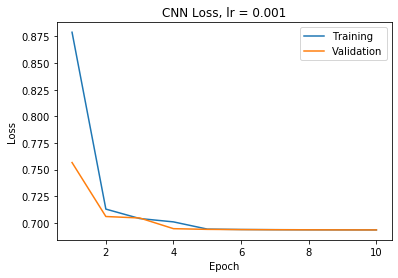

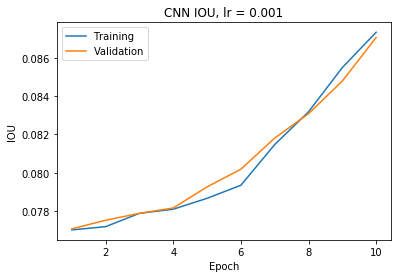

In [16]:
plot()

In [17]:
# Hyperparameters
epochs = 10
threshold = 0.5
learning_rate = 0.01
momentum = 0.9
selected_model = "CNN"

classifier, loss_function, optimizer = select_model()
training_losses = []
training_ious = []
validation_losses = []
validation_ious = []
print("Training on", selected_model)
print("Hyperparameters:\n",
      "\ntrain_split:", train_split,
      "\nbatch_size:", batch_size,
      "\nepochs:", epochs,
      "\nthreshold:", threshold,
      "\nlearning_rate:", learning_rate,
      "\nmomentum:", momentum,
      "\nselected_model:", selected_model,
      "\nloss_function:", "BCEWithLogitsLoss",
     )
for epoch in range(0, epochs):
    print("\nstarting epoch:", epoch + 1)
    training_loss, training_precision, training_recall, training_f1_score, training_iou = train(train_data_loader, classifier, loss_function, optimizer, threshold)
    training_losses.append(training_loss)
    training_ious.append(training_iou)
    print(selected_model, "results for epoch", epoch + 1)
    print("training_loss:", training_loss)
    print("training_iou:", training_iou)
    print("training_recall:", training_recall)
    print("training_precision:", training_precision)
    print("training_f1_score:", training_f1_score, "\n")
    
    validation_loss, validation_precision, validation_recall, validation_f1_score, validation_iou  = validate(validation_data_loader, classifier, loss_function, threshold)
    validation_losses.append(validation_loss)
    validation_ious.append(validation_iou)
    print("validation_loss:", validation_loss)
    print("validation_iou:", validation_iou)
    print("validation_recall:", validation_recall)
    print("validation_precision:", validation_precision)
    print("validation_f1_score:", validation_f1_score, "\n\n")

Training on CNN
Hyperparameters:
 
train_split: 0.7 
batch_size: 20 
epochs: 10 
threshold: 0.5 
learning_rate: 0.01 
momentum: 0.9 
selected_model: CNN 
loss_function: BCEWithLogitsLoss

starting epoch: 1
CNN results for epoch 1
training_loss: 0.735406363975106
training_iou: 0.06136819499312607
training_recall: 0.7129672447013489
training_precision: 0.06301451462323704
training_f1_score: 0.11247358721289619 

validation_loss: 0.6931980646945335
validation_iou: 0.05489011761941363
validation_recall: 0.5755743243243242
validation_precision: 0.056835392625834036
validation_f1_score: 0.09986436903703821 



starting epoch: 2
CNN results for epoch 2
training_loss: 0.6931732610470986
training_iou: 0.05504771140501968
training_recall: 0.5534441233140658
training_precision: 0.057918234182697155
training_f1_score: 0.09899555722031336 

validation_loss: 0.693185288358379
validation_iou: 0.0523238643585009
validation_recall: 0.5408333333333333
validation_precision: 0.054008034231525136
validatio

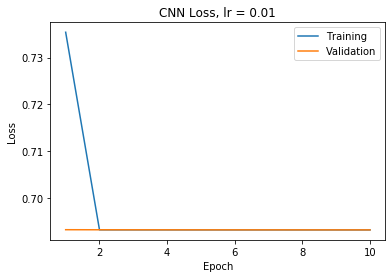

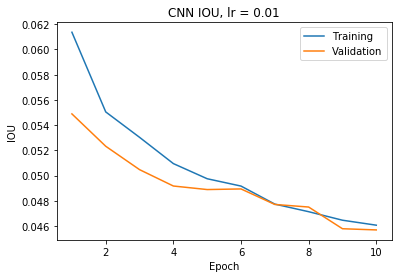

In [18]:
plot()

In [19]:
# Hyperparameters
epochs = 10
threshold = 0.5
learning_rate = 0.1
momentum = 0.9
selected_model = "CNN"

classifier, loss_function, optimizer = select_model()
training_losses = []
training_ious = []
validation_losses = []
validation_ious = []
print("Training on", selected_model)
print("Hyperparameters:\n",
      "\ntrain_split:", train_split,
      "\nbatch_size:", batch_size,
      "\nepochs:", epochs,
      "\nthreshold:", threshold,
      "\nlearning_rate:", learning_rate,
      "\nmomentum:", momentum,
      "\nselected_model:", selected_model,
      "\nloss_function:", "BCEWithLogitsLoss",
     )
for epoch in range(0, epochs):
    print("\nstarting epoch:", epoch + 1)
    training_loss, training_precision, training_recall, training_f1_score, training_iou = train(train_data_loader, classifier, loss_function, optimizer, threshold)
    training_losses.append(training_loss)
    training_ious.append(training_iou)
    print(selected_model, "results for epoch", epoch + 1)
    print("training_loss:", training_loss)
    print("training_iou:", training_iou)
    print("training_recall:", training_recall)
    print("training_precision:", training_precision)
    print("training_f1_score:", training_f1_score, "\n")
    
    validation_loss, validation_precision, validation_recall, validation_f1_score, validation_iou  = validate(validation_data_loader, classifier, loss_function, threshold)
    validation_losses.append(validation_loss)
    validation_ious.append(validation_iou)
    print("validation_loss:", validation_loss)
    print("validation_iou:", validation_iou)
    print("validation_recall:", validation_recall)
    print("validation_precision:", validation_precision)
    print("validation_f1_score:", validation_f1_score, "\n\n")

Training on CNN
Hyperparameters:
 
train_split: 0.7 
batch_size: 20 
epochs: 10 
threshold: 0.5 
learning_rate: 0.1 
momentum: 0.9 
selected_model: CNN 
loss_function: BCEWithLogitsLoss

starting epoch: 1
CNN results for epoch 1
training_loss: 0.7105516157398334
training_iou: 0.008956911090404923
training_recall: 0.1008863198458574
training_precision: 0.00940507885071141
training_f1_score: 0.01562815209441906 

validation_loss: 0.6931471824645996
validation_iou: 0.0
validation_recall: 0.0
validation_precision: 0.0
validation_f1_score: 0.0 



starting epoch: 2
CNN results for epoch 2
training_loss: 0.6931471824645996
training_iou: 0.0
training_recall: 0.0
training_precision: 0.0
training_f1_score: 0.0 

validation_loss: 0.6931471824645996
validation_iou: 0.0
validation_recall: 0.0
validation_precision: 0.0
validation_f1_score: 0.0 



starting epoch: 3
CNN results for epoch 3
training_loss: 0.6931471824645996
training_iou: 0.0
training_recall: 0.0
training_precision: 0.0
training_f1_sc

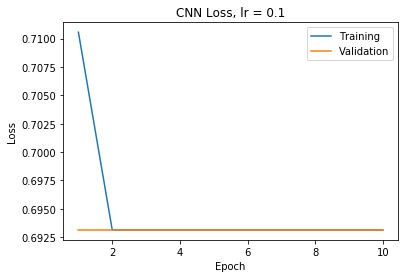

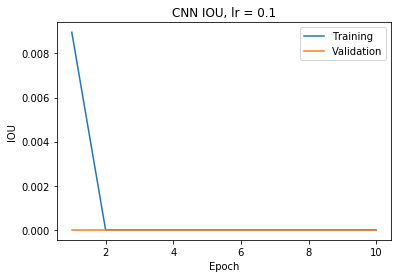

In [20]:
plot()

In [21]:
# Hyperparameters
epochs = 10
threshold = 0.5
learning_rate = 0.001
momentum = 0.9
selected_model = "Googlenet"

classifier, loss_function, optimizer = select_model()
training_losses = []
training_ious = []
validation_losses = []
validation_ious = []
print("Training on", selected_model)
print("Hyperparameters:\n",
      "\ntrain_split:", train_split,
      "\nbatch_size:", batch_size,
      "\nepochs:", epochs,
      "\nthreshold:", threshold,
      "\nlearning_rate:", learning_rate,
      "\nmomentum:", momentum,
      "\nselected_model:", selected_model,
      "\nloss_function:", "BCEWithLogitsLoss",
     )
for epoch in range(0, epochs):
    print("\nstarting epoch:", epoch + 1)
    training_loss, training_precision, training_recall, training_f1_score, training_iou = train(train_data_loader, classifier, loss_function, optimizer, threshold)
    training_losses.append(training_loss)
    training_ious.append(training_iou)
    print(selected_model, "results for epoch", epoch + 1)
    print("training_loss:", training_loss)
    print("training_iou:", training_iou)
    print("training_recall:", training_recall)
    print("training_precision:", training_precision)
    print("training_f1_score:", training_f1_score, "\n")
    
    validation_loss, validation_precision, validation_recall, validation_f1_score, validation_iou  = validate(validation_data_loader, classifier, loss_function, threshold)
    validation_losses.append(validation_loss)
    validation_ious.append(validation_iou)
    print("validation_loss:", validation_loss)
    print("validation_iou:", validation_iou)
    print("validation_recall:", validation_recall)
    print("validation_precision:", validation_precision)
    print("validation_f1_score:", validation_f1_score, "\n\n")
    

Training on Googlenet
Hyperparameters:
 
train_split: 0.7 
batch_size: 20 
epochs: 10 
threshold: 0.5 
learning_rate: 0.001 
momentum: 0.9 
selected_model: Googlenet 
loss_function: BCEWithLogitsLoss

starting epoch: 1
Googlenet results for epoch 1
training_loss: 0.38334702523802056
training_iou: 0.057571601487786485
training_recall: 0.0964547206165703
training_precision: 0.0898097575192951
training_f1_score: 0.0743502163049084 

validation_loss: 0.2722863703966141
validation_iou: 0.06798423423423419
validation_recall: 0.06798423423423419
validation_precision: 0.11486486486486487
validation_f1_score: 0.08166666666666676 



starting epoch: 2
Googlenet results for epoch 2
training_loss: 0.25072438308613837
training_iou: 0.08042870905587671
training_recall: 0.08042870905587671
training_precision: 0.12947976878612716
training_f1_score: 0.09515964767409867 

validation_loss: 0.24462729974372968
validation_iou: 0.08786036036036032
validation_recall: 0.08786036036036032
validation_precision:

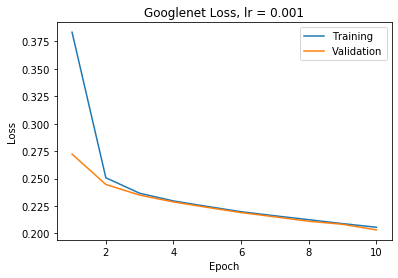

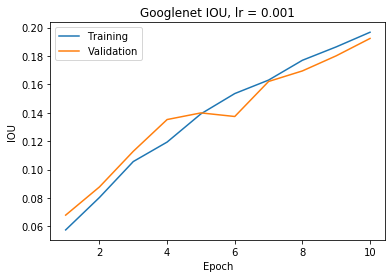

In [22]:
plot()

In [23]:
# Hyperparameters
epochs = 10
threshold = 0.5
learning_rate = 0.01
momentum = 0.9
selected_model = "Googlenet"

classifier, loss_function, optimizer = select_model()
training_losses = []
training_ious = []
validation_losses = []
validation_ious = []
print("Training on", selected_model)
print("Hyperparameters:\n",
      "\ntrain_split:", train_split,
      "\nbatch_size:", batch_size,
      "\nepochs:", epochs,
      "\nthreshold:", threshold,
      "\nlearning_rate:", learning_rate,
      "\nmomentum:", momentum,
      "\nselected_model:", selected_model,
      "\nloss_function:", "BCEWithLogitsLoss",
     )
for epoch in range(0, epochs):
    print("\nstarting epoch:", epoch + 1)
    training_loss, training_precision, training_recall, training_f1_score, training_iou = train(train_data_loader, classifier, loss_function, optimizer, threshold)
    training_losses.append(training_loss)
    training_ious.append(training_iou)
    print(selected_model, "results for epoch", epoch + 1)
    print("training_loss:", training_loss)
    print("training_iou:", training_iou)
    print("training_recall:", training_recall)
    print("training_precision:", training_precision)
    print("training_f1_score:", training_f1_score, "\n")
    
    validation_loss, validation_precision, validation_recall, validation_f1_score, validation_iou  = validate(validation_data_loader, classifier, loss_function, threshold)
    validation_losses.append(validation_loss)
    validation_ious.append(validation_iou)
    print("validation_loss:", validation_loss)
    print("validation_iou:", validation_iou)
    print("validation_recall:", validation_recall)
    print("validation_precision:", validation_precision)
    print("validation_f1_score:", validation_f1_score, "\n\n")

Training on Googlenet
Hyperparameters:
 
train_split: 0.7 
batch_size: 20 
epochs: 10 
threshold: 0.5 
learning_rate: 0.01 
momentum: 0.9 
selected_model: Googlenet 
loss_function: BCEWithLogitsLoss

starting epoch: 1
Googlenet results for epoch 1
training_loss: 0.2506339467329786
training_iou: 0.13612048247758873
training_recall: 0.1494749518304429
training_precision: 0.21386426727339683
training_f1_score: 0.16183753866557363 

validation_loss: 0.2059299144390467
validation_iou: 0.17802927927927936
validation_recall: 0.17802927927927936
validation_precision: 0.2905405405405405
validation_f1_score: 0.21234234234234234 



starting epoch: 2
Googlenet results for epoch 2
training_loss: 0.19246090087242898
training_iou: 0.23330443159922956
training_recall: 0.23330443159922956
training_precision: 0.3546242774566474
training_f1_score: 0.2704101293696645 

validation_loss: 0.1771096166323971
validation_iou: 0.26603603603603565
validation_recall: 0.26654279279279247
validation_precision: 0.41

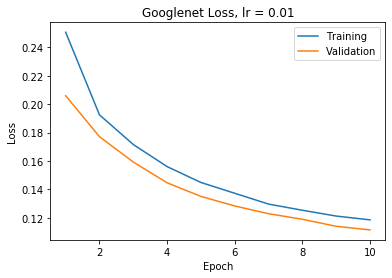

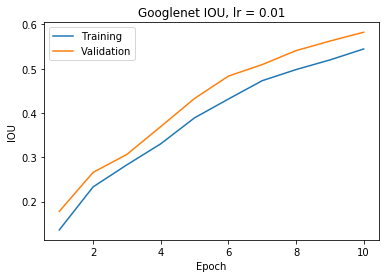

In [24]:
plot()

In [25]:
# Hyperparameters
epochs = 10
threshold = 0.5
learning_rate = 0.1
momentum = 0.9
selected_model = "Googlenet"

classifier, loss_function, optimizer = select_model()
training_losses = []
training_ious = []
validation_losses = []
validation_ious = []
print("Training on", selected_model)
print("Hyperparameters:\n",
      "\ntrain_split:", train_split,
      "\nbatch_size:", batch_size,
      "\nepochs:", epochs,
      "\nthreshold:", threshold,
      "\nlearning_rate:", learning_rate,
      "\nmomentum:", momentum,
      "\nselected_model:", selected_model,
      "\nloss_function:", "BCEWithLogitsLoss",
     )
for epoch in range(0, epochs):
    print("\nstarting epoch:", epoch + 1)
    training_loss, training_precision, training_recall, training_f1_score, training_iou = train(train_data_loader, classifier, loss_function, optimizer, threshold)
    training_losses.append(training_loss)
    training_ious.append(training_iou)
    print(selected_model, "results for epoch", epoch + 1)
    print("training_loss:", training_loss)
    print("training_iou:", training_iou)
    print("training_recall:", training_recall)
    print("training_precision:", training_precision)
    print("training_f1_score:", training_f1_score, "\n")
    
    validation_loss, validation_precision, validation_recall, validation_f1_score, validation_iou  = validate(validation_data_loader, classifier, loss_function, threshold)
    validation_losses.append(validation_loss)
    validation_ious.append(validation_iou)
    print("validation_loss:", validation_loss)
    print("validation_iou:", validation_iou)
    print("validation_recall:", validation_recall)
    print("validation_precision:", validation_precision)
    print("validation_f1_score:", validation_f1_score, "\n\n")

Training on Googlenet
Hyperparameters:
 
train_split: 0.7 
batch_size: 20 
epochs: 10 
threshold: 0.5 
learning_rate: 0.1 
momentum: 0.9 
selected_model: Googlenet 
loss_function: BCEWithLogitsLoss

starting epoch: 1
Googlenet results for epoch 1
training_loss: 0.1766113812006967
training_iou: 0.36060570210136694
training_recall: 0.37606936416184983
training_precision: 0.4826661913872899
training_f1_score: 0.4028048332528111 

validation_loss: 0.11544074138274064
validation_iou: 0.5790878378378379
validation_recall: 0.5945833333333335
validation_precision: 0.7072072072072073
validation_f1_score: 0.6259202059202031 



starting epoch: 2
Googlenet results for epoch 2
training_loss: 0.1117322885059897
training_iou: 0.5921435452793828
training_recall: 0.621979768786127
training_precision: 0.7158574181117536
training_f1_score: 0.6424738508120048 

validation_loss: 0.09871950514010482
validation_iou: 0.6675225225225225
validation_recall: 0.7076689189189187
validation_precision: 0.77967342342

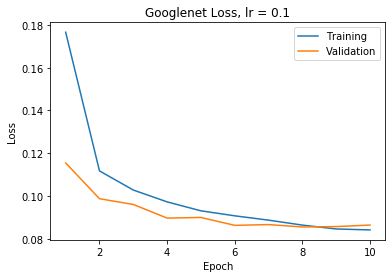

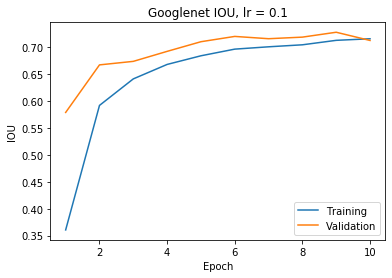

In [26]:
plot()

In [27]:
# Hyperparameters
epochs = 10
threshold = 0.5
learning_rate = 0.001
momentum = 0.9
selected_model = "Alexnet"

classifier, loss_function, optimizer = select_model()
training_losses = []
training_ious = []
validation_losses = []
validation_ious = []
print("Training on", selected_model)
print("Hyperparameters:\n",
      "\ntrain_split:", train_split,
      "\nbatch_size:", batch_size,
      "\nepochs:", epochs,
      "\nthreshold:", threshold,
      "\nlearning_rate:", learning_rate,
      "\nmomentum:", momentum,
      "\nselected_model:", selected_model,
      "\nloss_function:", "BCEWithLogitsLoss",
     )
for epoch in range(0, epochs):
    print("\nstarting epoch:", epoch + 1)
    training_loss, training_precision, training_recall, training_f1_score, training_iou = train(train_data_loader, classifier, loss_function, optimizer, threshold)
    training_losses.append(training_loss)
    training_ious.append(training_iou)
    print(selected_model, "results for epoch", epoch + 1)
    print("training_loss:", training_loss)
    print("training_iou:", training_iou)
    print("training_recall:", training_recall)
    print("training_precision:", training_precision)
    print("training_f1_score:", training_f1_score, "\n")
    
    validation_loss, validation_precision, validation_recall, validation_f1_score, validation_iou  = validate(validation_data_loader, classifier, loss_function, threshold)
    validation_losses.append(validation_loss)
    validation_ious.append(validation_iou)
    print("validation_loss:", validation_loss)
    print("validation_iou:", validation_iou)
    print("validation_recall:", validation_recall)
    print("validation_precision:", validation_precision)
    print("validation_f1_score:", validation_f1_score, "\n\n")

Training on Alexnet
Hyperparameters:
 
train_split: 0.7 
batch_size: 20 
epochs: 10 
threshold: 0.5 
learning_rate: 0.001 
momentum: 0.9 
selected_model: Alexnet 
loss_function: BCEWithLogitsLoss

starting epoch: 1
Alexnet results for epoch 1
training_loss: 0.26478211865948803
training_iou: 0.22021959976439778
training_recall: 0.2514113680154148
training_precision: 0.3374202932584435
training_f1_score: 0.26227413336219624 

validation_loss: 0.18371625909128705
validation_iou: 0.30956081081081055
validation_recall: 0.313502252252252
validation_precision: 0.4507882882882883
validation_f1_score: 0.35443693693693823 



starting epoch: 2
Alexnet results for epoch 2
training_loss: 0.16166704234188004
training_iou: 0.3683044315992296
training_recall: 0.37629576107899815
training_precision: 0.5071290944123313
training_f1_score: 0.4141859344894048 

validation_loss: 0.15439634880906827
validation_iou: 0.4470334620334624
validation_recall: 0.46406531531531564
validation_precision: 0.57989864864

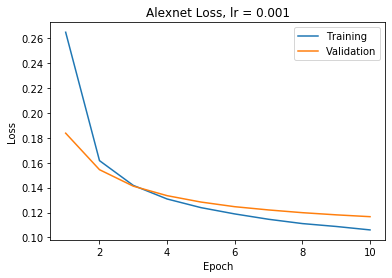

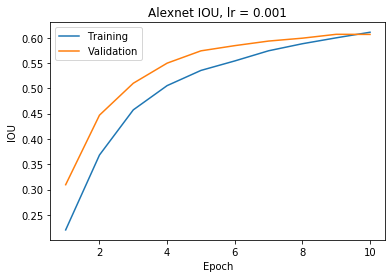

In [28]:
plot()

In [29]:
# Hyperparameters
epochs = 10
threshold = 0.5
learning_rate = 0.01
momentum = 0.9
selected_model = "Alexnet"

classifier, loss_function, optimizer = select_model()
training_losses = []
training_ious = []
validation_losses = []
validation_ious = []
print("Training on", selected_model)
print("Hyperparameters:\n",
      "\ntrain_split:", train_split,
      "\nbatch_size:", batch_size,
      "\nepochs:", epochs,
      "\nthreshold:", threshold,
      "\nlearning_rate:", learning_rate,
      "\nmomentum:", momentum,
      "\nselected_model:", selected_model,
      "\nloss_function:", "BCEWithLogitsLoss",
     )
for epoch in range(0, epochs):
    print("\nstarting epoch:", epoch + 1)
    training_loss, training_precision, training_recall, training_f1_score, training_iou = train(train_data_loader, classifier, loss_function, optimizer, threshold)
    training_losses.append(training_loss)
    training_ious.append(training_iou)
    print(selected_model, "results for epoch", epoch + 1)
    print("training_loss:", training_loss)
    print("training_iou:", training_iou)
    print("training_recall:", training_recall)
    print("training_precision:", training_precision)
    print("training_f1_score:", training_f1_score, "\n")
    
    validation_loss, validation_precision, validation_recall, validation_f1_score, validation_iou  = validate(validation_data_loader, classifier, loss_function, threshold)
    validation_losses.append(validation_loss)
    validation_ious.append(validation_iou)
    print("validation_loss:", validation_loss)
    print("validation_iou:", validation_iou)
    print("validation_recall:", validation_recall)
    print("validation_precision:", validation_precision)
    print("validation_f1_score:", validation_f1_score, "\n\n")

Training on Alexnet
Hyperparameters:
 
train_split: 0.7 
batch_size: 20 
epochs: 10 
threshold: 0.5 
learning_rate: 0.01 
momentum: 0.9 
selected_model: Alexnet 
loss_function: BCEWithLogitsLoss

starting epoch: 1
Alexnet results for epoch 1
training_loss: 0.16187256996686747
training_iou: 0.46658201785369374
training_recall: 0.5046868978805391
training_precision: 0.5869305076747277
training_f1_score: 0.5171204742592067 

validation_loss: 0.11935720854514353
validation_iou: 0.6158236808236813
validation_recall: 0.6695495495495498
validation_precision: 0.7217905405405404
validation_f1_score: 0.6705759330759294 



starting epoch: 2
Alexnet results for epoch 2
training_loss: 0.10467133083181575
training_iou: 0.6260163776493252
training_recall: 0.662100192678227
training_precision: 0.7422687861271676
training_f1_score: 0.676654968345722 

validation_loss: 0.11262957248333338
validation_iou: 0.6302252252252255
validation_recall: 0.6900450450450452
validation_precision: 0.7339527027027024
v

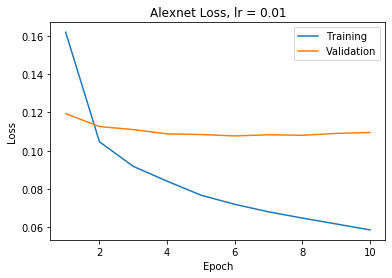

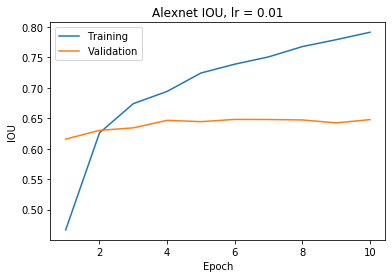

In [30]:
plot()

In [31]:
# Hyperparameters
epochs = 10
threshold = 0.5
learning_rate = 0.1
momentum = 0.9
selected_model = "Alexnet"

classifier, loss_function, optimizer = select_model()
training_losses = []
training_ious = []
validation_losses = []
validation_ious = []
print("Training on", selected_model)
print("Hyperparameters:\n",
      "\ntrain_split:", train_split,
      "\nbatch_size:", batch_size,
      "\nepochs:", epochs,
      "\nthreshold:", threshold,
      "\nlearning_rate:", learning_rate,
      "\nmomentum:", momentum,
      "\nselected_model:", selected_model,
      "\nloss_function:", "BCEWithLogitsLoss",
     )
for epoch in range(0, epochs):
    print("\nstarting epoch:", epoch + 1)
    training_loss, training_precision, training_recall, training_f1_score, training_iou = train(train_data_loader, classifier, loss_function, optimizer, threshold)
    training_losses.append(training_loss)
    training_ious.append(training_iou)
    print(selected_model, "results for epoch", epoch + 1)
    print("training_loss:", training_loss)
    print("training_iou:", training_iou)
    print("training_recall:", training_recall)
    print("training_precision:", training_precision)
    print("training_f1_score:", training_f1_score, "\n")
    
    validation_loss, validation_precision, validation_recall, validation_f1_score, validation_iou  = validate(validation_data_loader, classifier, loss_function, threshold)
    validation_losses.append(validation_loss)
    validation_ious.append(validation_iou)
    print("validation_loss:", validation_loss)
    print("validation_iou:", validation_iou)
    print("validation_recall:", validation_recall)
    print("validation_precision:", validation_precision)
    print("validation_f1_score:", validation_f1_score, "\n\n")

Training on Alexnet
Hyperparameters:
 
train_split: 0.7 
batch_size: 20 
epochs: 10 
threshold: 0.5 
learning_rate: 0.1 
momentum: 0.9 
selected_model: Alexnet 
loss_function: BCEWithLogitsLoss

starting epoch: 1
Alexnet results for epoch 1
training_loss: 0.22877804904831628
training_iou: 0.5113257054442014
training_recall: 0.604542389210019
training_precision: 0.6067436705876016
training_f1_score: 0.5761521450611107 

validation_loss: 0.18502929655684008
validation_iou: 0.5921798584298587
validation_recall: 0.7065990990990989
validation_precision: 0.6818918918918918
validation_f1_score: 0.6634191334191284 



starting epoch: 2
Alexnet results for epoch 2
training_loss: 0.1469412382713632
training_iou: 0.659133636113405
training_recall: 0.7491714836223509
training_precision: 0.7490847784200387
training_f1_score: 0.7217107074043506 

validation_loss: 0.2053822776353037
validation_iou: 0.5929584942084947
validation_recall: 0.7153603603603609
validation_precision: 0.6699436936936936
valid

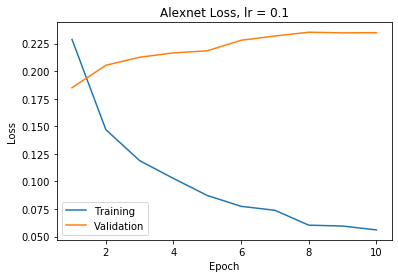

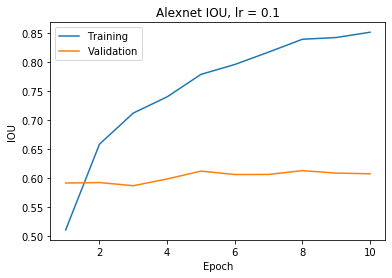

In [32]:
plot()

In [33]:
# Hyperparameters
epochs = 10
threshold = 0.5
learning_rate = 0.001
momentum = 0.9
selected_model = "Resnet18"

classifier, loss_function, optimizer = select_model()
training_losses = []
training_ious = []
validation_losses = []
validation_ious = []
print("Training on", selected_model)
print("Hyperparameters:\n",
      "\ntrain_split:", train_split,
      "\nbatch_size:", batch_size,
      "\nepochs:", epochs,
      "\nthreshold:", threshold,
      "\nlearning_rate:", learning_rate,
      "\nmomentum:", momentum,
      "\nselected_model:", selected_model,
      "\nloss_function:", "BCEWithLogitsLoss",
     )
for epoch in range(0, epochs):
    print("\nstarting epoch:", epoch + 1)
    training_loss, training_precision, training_recall, training_f1_score, training_iou = train(train_data_loader, classifier, loss_function, optimizer, threshold)
    training_losses.append(training_loss)
    training_ious.append(training_iou)
    print(selected_model, "results for epoch", epoch + 1)
    print("training_loss:", training_loss)
    print("training_iou:", training_iou)
    print("training_recall:", training_recall)
    print("training_precision:", training_precision)
    print("training_f1_score:", training_f1_score, "\n")
    
    validation_loss, validation_precision, validation_recall, validation_f1_score, validation_iou  = validate(validation_data_loader, classifier, loss_function, threshold)
    validation_losses.append(validation_loss)
    validation_ious.append(validation_iou)
    print("validation_loss:", validation_loss)
    print("validation_iou:", validation_iou)
    print("validation_recall:", validation_recall)
    print("validation_precision:", validation_precision)
    print("validation_f1_score:", validation_f1_score, "\n\n")

Training on Resnet18
Hyperparameters:
 
train_split: 0.7 
batch_size: 20 
epochs: 10 
threshold: 0.5 
learning_rate: 0.001 
momentum: 0.9 
selected_model: Resnet18 
loss_function: BCEWithLogitsLoss

starting epoch: 1
Resnet18 results for epoch 1
training_loss: 0.29918930330717497
training_iou: 0.11650465141794615
training_recall: 0.15518786127167614
training_precision: 0.18170179210641638
training_f1_score: 0.14424490778027046 

validation_loss: 0.23194890368629145
validation_iou: 0.14101351351351363
validation_recall: 0.14101351351351363
validation_precision: 0.23108108108108108
validation_f1_score: 0.1687387387387383 



starting epoch: 2
Resnet18 results for epoch 2
training_loss: 0.22197925527660833
training_iou: 0.15197495183044296
training_recall: 0.15197495183044296
training_precision: 0.24421965317919075
training_f1_score: 0.1801211120286262 

validation_loss: 0.21534234869319038
validation_iou: 0.15421171171171183
validation_recall: 0.15421171171171183
validation_precision: 0.

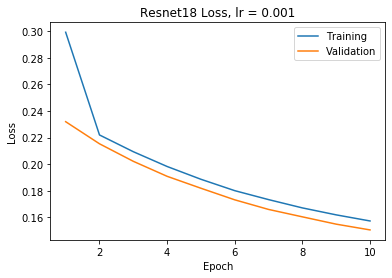

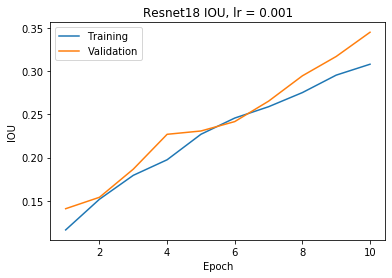

In [34]:
plot()

In [35]:
# Hyperparameters
epochs = 10
threshold = 0.5
learning_rate = 0.01
momentum = 0.9
selected_model = "Resnet18"

classifier, loss_function, optimizer = select_model()
training_losses = []
training_ious = []
validation_losses = []
validation_ious = []
print("Training on", selected_model)
print("Hyperparameters:\n",
      "\ntrain_split:", train_split,
      "\nbatch_size:", batch_size,
      "\nepochs:", epochs,
      "\nthreshold:", threshold,
      "\nlearning_rate:", learning_rate,
      "\nmomentum:", momentum,
      "\nselected_model:", selected_model,
      "\nloss_function:", "BCEWithLogitsLoss",
     )
for epoch in range(0, epochs):
    print("\nstarting epoch:", epoch + 1)
    training_loss, training_precision, training_recall, training_f1_score, training_iou = train(train_data_loader, classifier, loss_function, optimizer, threshold)
    training_losses.append(training_loss)
    training_ious.append(training_iou)
    print(selected_model, "results for epoch", epoch + 1)
    print("training_loss:", training_loss)
    print("training_iou:", training_iou)
    print("training_recall:", training_recall)
    print("training_precision:", training_precision)
    print("training_f1_score:", training_f1_score, "\n")
    
    validation_loss, validation_precision, validation_recall, validation_f1_score, validation_iou  = validate(validation_data_loader, classifier, loss_function, threshold)
    validation_losses.append(validation_loss)
    validation_ious.append(validation_iou)
    print("validation_loss:", validation_loss)
    print("validation_iou:", validation_iou)
    print("validation_recall:", validation_recall)
    print("validation_precision:", validation_precision)
    print("validation_f1_score:", validation_f1_score, "\n\n")

Training on Resnet18
Hyperparameters:
 
train_split: 0.7 
batch_size: 20 
epochs: 10 
threshold: 0.5 
learning_rate: 0.01 
momentum: 0.9 
selected_model: Resnet18 
loss_function: BCEWithLogitsLoss

starting epoch: 1
Resnet18 results for epoch 1
training_loss: 0.21501459646431698
training_iou: 0.20094479621213746
training_recall: 0.21180154142581908
training_precision: 0.31328142634501016
training_f1_score: 0.23715626217071148 

validation_loss: 0.15163643235290372
validation_iou: 0.346441441441441
validation_recall: 0.3489189189189186
validation_precision: 0.49932432432432433
validation_f1_score: 0.39427927927927964 



starting epoch: 2
Resnet18 results for epoch 2
training_loss: 0.14225815357155883
training_iou: 0.39556840077071304
training_recall: 0.40390173410404623
training_precision: 0.539306358381503
training_f1_score: 0.44325557390586506 

validation_loss: 0.12468195797221081
validation_iou: 0.5229504504504512
validation_recall: 0.5452590090090096
validation_precision: 0.662162

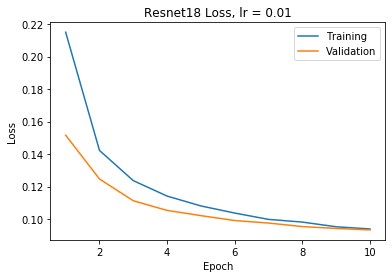

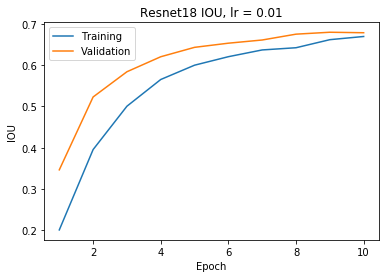

In [36]:
plot()

In [37]:
# Hyperparameters
epochs = 10
threshold = 0.5
learning_rate = 0.1
momentum = 0.9
selected_model = "Resnet18"

classifier, loss_function, optimizer = select_model()
training_losses = []
training_ious = []
validation_losses = []
validation_ious = []
print("Training on", selected_model)
print("Hyperparameters:\n",
      "\ntrain_split:", train_split,
      "\nbatch_size:", batch_size,
      "\nepochs:", epochs,
      "\nthreshold:", threshold,
      "\nlearning_rate:", learning_rate,
      "\nmomentum:", momentum,
      "\nselected_model:", selected_model,
      "\nloss_function:", "BCEWithLogitsLoss",
     )
for epoch in range(0, epochs):
    print("\nstarting epoch:", epoch + 1)
    training_loss, training_precision, training_recall, training_f1_score, training_iou = train(train_data_loader, classifier, loss_function, optimizer, threshold)
    training_losses.append(training_loss)
    training_ious.append(training_iou)
    print(selected_model, "results for epoch", epoch + 1)
    print("training_loss:", training_loss)
    print("training_iou:", training_iou)
    print("training_recall:", training_recall)
    print("training_precision:", training_precision)
    print("training_f1_score:", training_f1_score, "\n")
    
    validation_loss, validation_precision, validation_recall, validation_f1_score, validation_iou  = validate(validation_data_loader, classifier, loss_function, threshold)
    validation_losses.append(validation_loss)
    validation_ious.append(validation_iou)
    print("validation_loss:", validation_loss)
    print("validation_iou:", validation_iou)
    print("validation_recall:", validation_recall)
    print("validation_precision:", validation_precision)
    print("validation_f1_score:", validation_f1_score, "\n\n")

Training on Resnet18
Hyperparameters:
 
train_split: 0.7 
batch_size: 20 
epochs: 10 
threshold: 0.5 
learning_rate: 0.1 
momentum: 0.9 
selected_model: Resnet18 
loss_function: BCEWithLogitsLoss

starting epoch: 1
Resnet18 results for epoch 1
training_loss: 0.154298739970764
training_iou: 0.5142718120030256
training_recall: 0.5579624277456645
training_precision: 0.6323597308279394
training_f1_score: 0.5673854693796945 

validation_loss: 0.10100787807558034
validation_iou: 0.6594594594594594
validation_recall: 0.7024662162162164
validation_precision: 0.7832207207207204
validation_f1_score: 0.7153185328185296 



starting epoch: 2
Resnet18 results for epoch 2
training_loss: 0.10105580145310115
training_iou: 0.666994219653179
training_recall: 0.7166522157996146
training_precision: 0.7729816955684006
training_f1_score: 0.7189902743370957 

validation_loss: 0.10705124264633334
validation_iou: 0.6761599099099103
validation_recall: 0.7628265765765766
validation_precision: 0.77481981981982
va

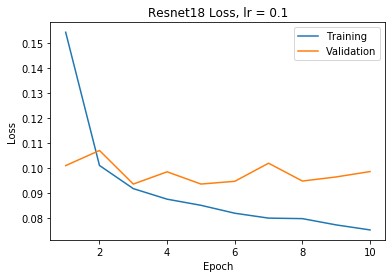

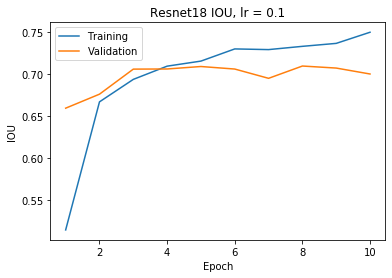

In [38]:
plot()